# Frequency Analysis

Run all cells in sequence.

In [2]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [1586]:
def analyze(x, delays, k, oversample = 1, alpha = 0.9, epsilon = 0.0001, delta = 0.1, gamma = 0.01, dtype = 'float', randomize = True, seed = False, track = False, pad = False):
    N = len(delays)
    x = x.astype(dtype)
    # ds = np.cumsum(delays)
    ds = np.array(delays)
    
    if pad:
        X = np.append(np.zeros(ds[-1], dtype = dtype), x)
    else:
        X = x
    
    A = np.eye(N,k, dtype = dtype)
    Y = np.random.random((N,N)) + (1j if dtype == 'complex' else 0) * np.random.random((N, N))
    Y = Y - np.conj(Y.T)
    if randomize:
        A = scipy.linalg.expm(Y) @ A
    elif seed:
        for i in range(k):
            A[:,i] = X[i * (len(X) - k - ds[-1]) // k + ds[-1] - ds]
            A[:,i] /= np.linalg.norm(A[:,i])
            
        for i in (tqdm(range(N)) if track else range(N)):
            A += 0.1 / N * A @ (np.eye(k) - np.conj(A.T) @ A)
        
        for i in range(k):
            A[:,i] /= np.linalg.norm(A[:,i])
    
    B = np.zeros((N,N), dtype = dtype)
    
    if pad:    
        trajectory = np.zeros((len(x), k), dtype = dtype)
        bases = np.zeros((len(x), N, k), dtype = dtype)
        distances = np.zeros(len(x), dtype = float)
    else:
        trajectory = np.zeros((len(x) - ds[-1], k), dtype = dtype)
        bases = np.zeros((len(x) - ds[-1], N, k), dtype = dtype)
        distances = np.zeros(len(x) - ds[-1], dtype = float)
    
    try:
        for i in (tqdm(range(ds[-1], len(X))) if track else range(ds[-1], len(X))):
            y = X[i - ds]
            B = alpha * B + np.outer(y,y) / (gamma + np.conj(y) @ y)
            # B = alpha * B + np.outer(y, y)
            for j in range(oversample):
                C = B @ A
                A += 1 / N * np.sqrt(k) * (C - A @ (np.conj(A.T) @ C))
                A += 1 / N * np.sqrt(k) * A @ (np.eye(k) - np.conj(A.T) @ A)
                
            trajectory[i - ds[-1]] = np.conj(A.T) @ y
            bases[i - ds[-1]] = A
            distances[i - ds[-1]] = (np.abs(np.conj(y) @ y) - np.abs(np.conj(trajectory[i - ds[-1]]) @ trajectory[i - ds[-1]])) / (gamma + np.abs(np.conj(y) @ y))
    except KeyboardInterrupt:
        return trajectory[:i-ds[-1]], bases[:i-ds[-1]], distances[:i-ds[-1]]
    
    return trajectory, bases, distances

In [1626]:
# fs = [60, -60, 440, -440, 330, -330, 189, -189] #, 2060, -2060, 788, -788, 921, -921, 1033, -1033, 89, -89]
k = 45
SR = 48000
bandlimit = 4
fs = np.random.rand(k) * SR / bandlimit # generate random frequencies up to SR / bandlimit
# N = k ** 2 #
N = bandlimit * k
M = 2 * N

phasor = 2 * np.pi * np.arange(0, M / SR, 1 / SR)
phases = np.array([phasor * f for f in fs])
source = np.exp(1j * phases)
# vectors = np.exp(1j * phases)
vectors = source[:,:N]

In [1627]:
synthetic = False

100%|█████████████████████████████████████████████████████████████████████████████████| 181/181 [00:02<00:00, 90.12it/s]


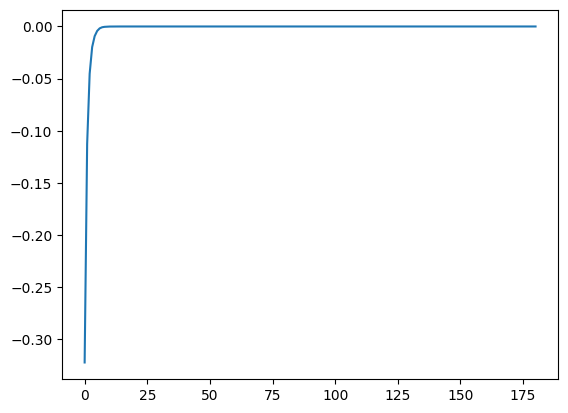

In [1628]:
if synthetic:
    A = vectors.T.copy()
    for i in tqdm(range(10000)):
        A += 0.1 / N * A @ (np.eye(k) - np.conj(A.T) @ A)
else:
    coeffs = np.ones(k)
    signal = source.T @ coeffs

    trajectory, bases, distances = analyze(signal, list(range(N)), k, dtype = complex, track = True, randomize = False, seed = True, oversample = 10)
    A = np.conj(bases[-1])
    plt.plot(distances)
    distances[-1]

Vectors & Correlation


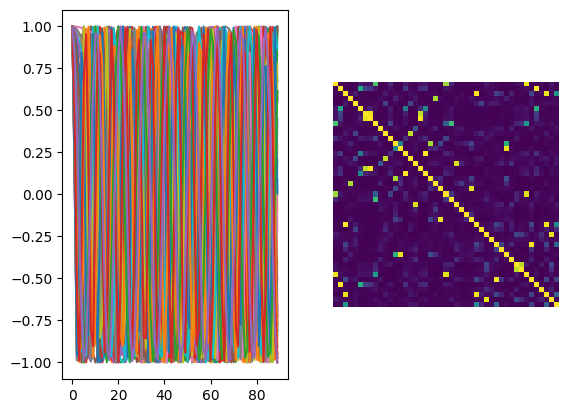

Orthonormalized & Correlation


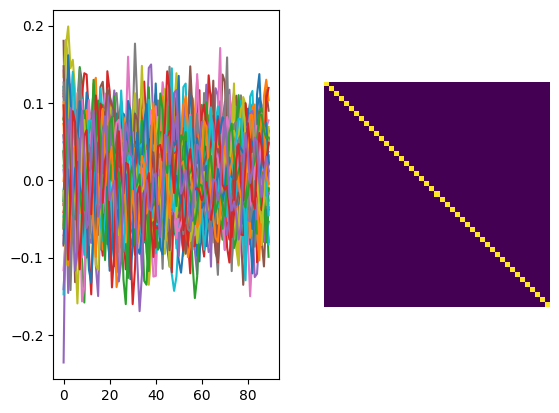

Mixed & Correlation


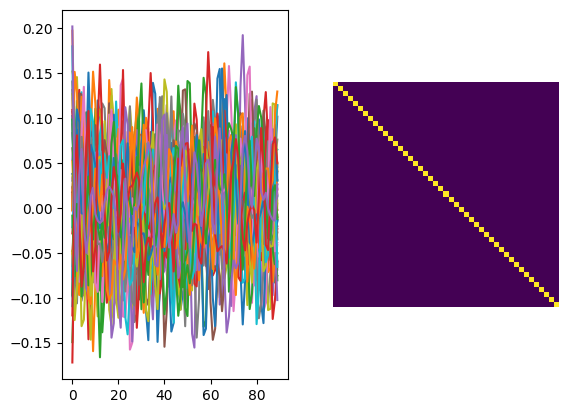

In [1629]:
print("Vectors & Correlation")
fig, ax = plt.subplots(ncols = 2, nrows = 1)
# ax[0].set_aspect(N  / 2)
ax[0].plot(np.real(vectors.T[:k * 2]))

# print("Correlation:")
ax[1].imshow(np.abs(np.conj(vectors) @ vectors.T))
ax[1].set_axis_off()
plt.show()

print("Orthonormalized & Correlation")
fig, ax = plt.subplots(ncols = 2, nrows = 1)

# ax[0].set_aspect(N  / 2)
ax[0].plot(np.real(A[:k * 2]))
ax[1].imshow(np.abs(np.conj(A.T) @ A))
ax[1].set_axis_off()
plt.show()

# generate random orthogonal matrix to right-mult by
Y = np.random.random((k,k)) + 1j * np.random.random((k, k))
Y = Y - np.conj(Y.T)
X = scipy.linalg.expm(Y)

# this is now the "mixed up" matrix that we would be handed, whose image
# spans that of vectors. the goal is to recover vectors
Z = A @ X

print("Mixed & Correlation")
fig, ax = plt.subplots(ncols = 2, nrows = 1)
ax[0].plot(np.real(Z[:k * 2]))
ax[1].imshow(np.abs(np.conj(Z.T) @ Z))
ax[1].set_axis_off()
plt.show()

In [1633]:
S = np.linalg.inv(np.conj(Z[:-1,:].T) @ Z[:-1,:]) @ np.conj(Z[:-1,:].T) @ Z[1:,:]

omegas = np.linalg.eigvals(S)

freqs = np.sort([np.angle(o) * SR / (2 * np.pi) for o in omegas])
fs = np.sort(fs)

print("Detected:", freqs, "\n")

print("True:", fs, "\n")

# compute errors by comparing each estimated frequency from freqs
# to nearest element of fs
errs = np.zeros(k)
for i,f in enumerate(freqs):
    errs[i] = f - fs[np.argmin(np.abs(f - fs))]

print("Errors", errs, "\n")

magnitude = np.log(np.abs(errs))
mean = np.mean(magnitude)

print("Typical accuracy:", np.exp(mean))

Detected: [-1497.05677277   248.37422298   725.0019349    765.8576677
  1072.21910239  1150.40958389  1283.17193207  1320.31427147
  1866.67634359  1941.76693888  2389.87068408  2896.91798219
  3103.32560976  3154.35086312  3532.91756642  3777.83253736
  4044.19771614  4359.52498457  4385.94759397  4579.94534841
  4740.18551135  4775.65324392  5266.49724868  5608.82668118
  5952.04175664  6016.67062571  6802.4339943   7792.44350363
  8380.00054285  8419.53710549  8783.28762586  8851.37942991
  9373.08616569  9495.62340089  9625.32454621  9692.49195221
  9917.0602477  10610.43114674 10612.15469374 10786.39680075
 10920.05727339 10925.80610159 11338.41831951 11375.64112413
 11404.75170132] 

True: [  248.3742298    725.0017418    765.85792261  1072.22024524
  1150.41371394  1283.15806408  1320.31076131  1866.67631202
  1941.76691372  2389.87068467  2896.91799485  3103.32533339
  3154.35066777  3777.83253611  4044.19737608  4359.10012416
  4385.40455076  4579.99985101  4736.88470092  4744